## Import Library

In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import seaborn as sns 
import matplotlib.pyplot as plt 
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error 
plt.style.use('fivethirtyeight')

## Import Data and do preprocessing
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region.

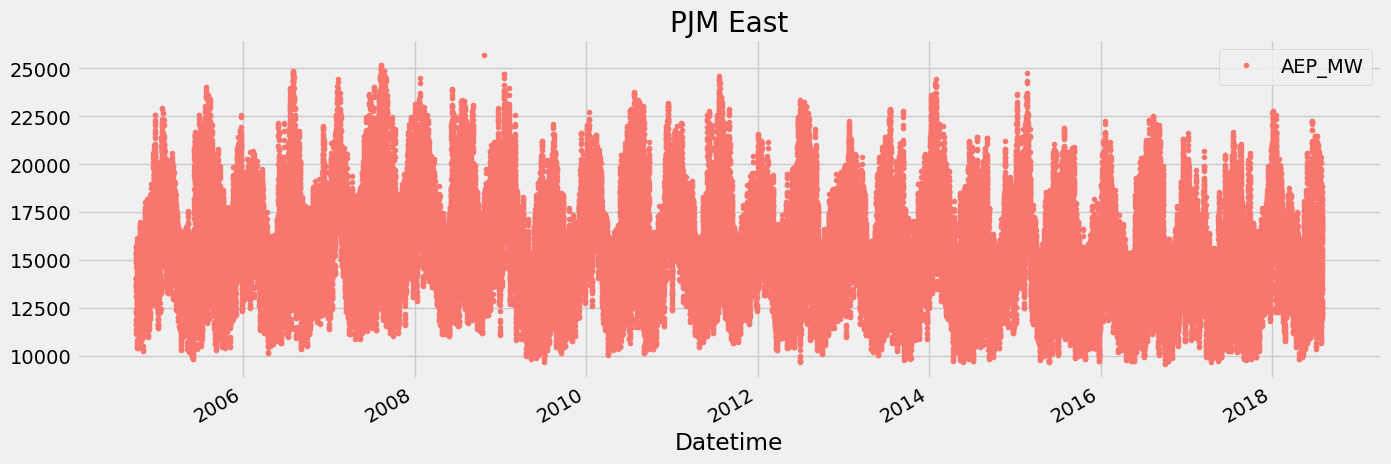

In [2]:
pjme = pd.read_csv('D:/[DOC]/MASH_/20250206/AEP_hourly.csv', index_col=[0], parse_dates=[0])
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [3]:
pjme.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


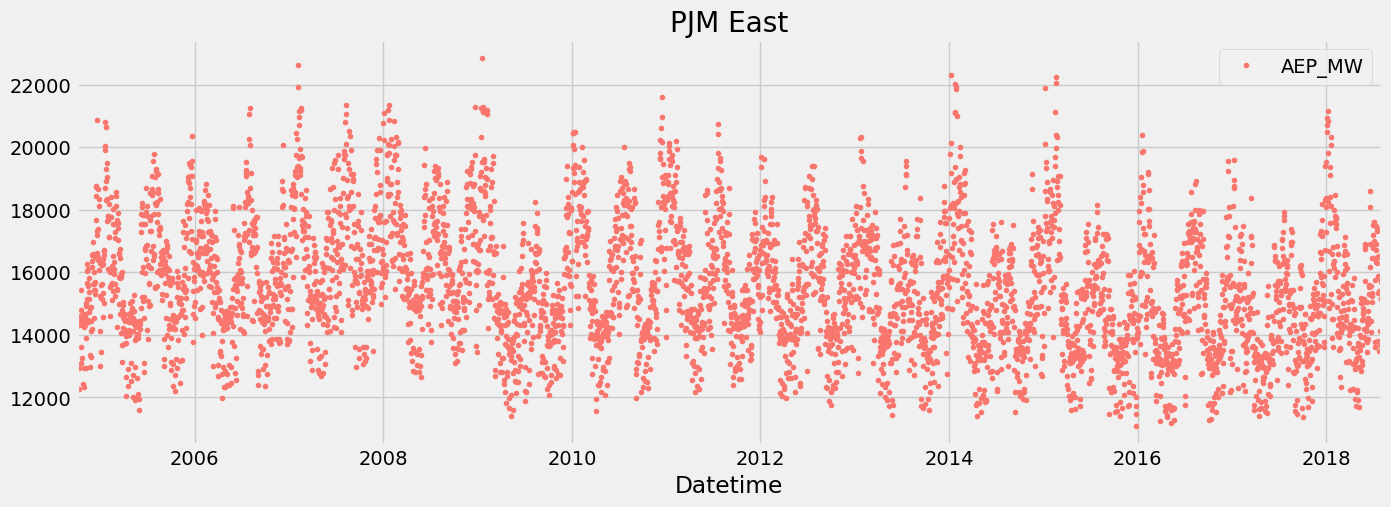

In [4]:
pjme = pjme.sort_index()    # 时间序列回归问题务必先排序
pjme = pjme.resample('D').mean()    # 降采样为每天数据，增加数据粒度，减轻VARMAX模型训练成本
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [5]:
pjme.head()

,AEP_MW
Datetime,
2004-10-01,14284.521739
2004-10-02,12999.875000
2004-10-03,12227.083333
2004-10-04,14309.041667
2004-10-05,14439.708333


## Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [6]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

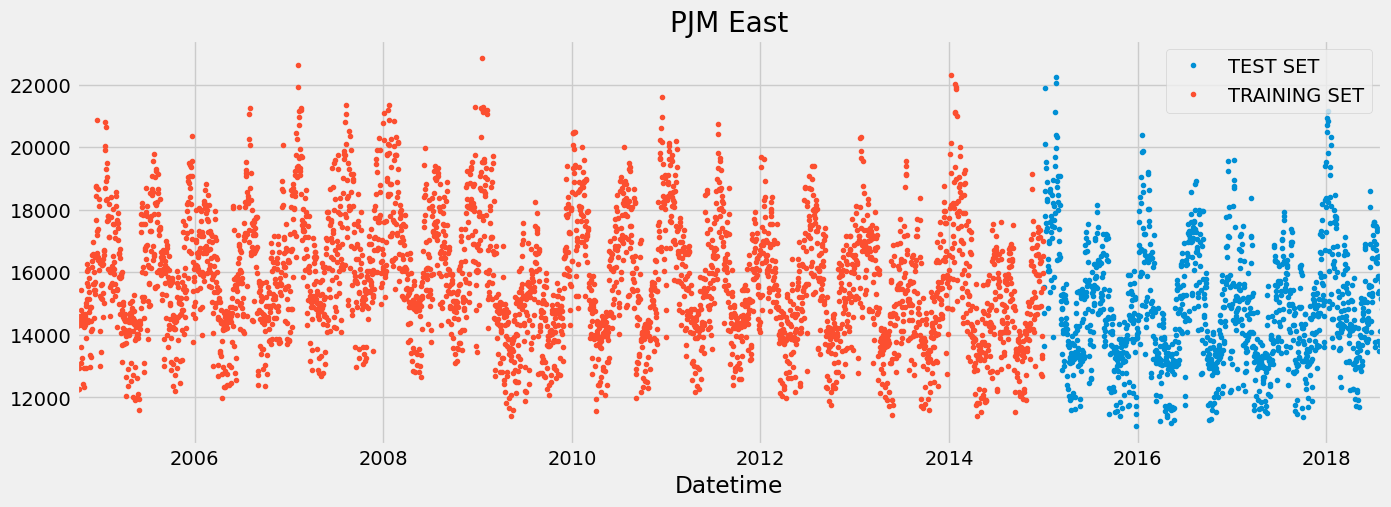

In [7]:
_ = pjme_test.rename(columns={'AEP_MW': 'TEST SET'}).join(pjme_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer').plot(figsize=(15,5), title='PJM East', style='.')

## Create Time Series Values

In [8]:
# X 为所有可用时间解释的变量(feature)；可只考虑较重要的特征维度，或采用降维后特征
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
##    df['hour'] = df['date'].dt.hour  # 如果不降采样, 数据粒度会过高，VARMAX 模型会消耗大量内存，训练时间会大于1小时
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
##    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[[label,'dayofweek','quarter','month','year', 'dayofyear','dayofmonth']]
    return X

In [9]:
X_train = create_features(pjme_train, label='AEP_MW')
X_test = create_features(pjme_test, label='AEP_MW')

In [10]:
X_train.head(100)

,AEP_MW,dayofweek,quarter,month,year,dayofyear,dayofmonth
Datetime,,,,,,,
2004-10-01,14284.521739,4,4,10,2004,275,1
2004-10-02,12999.875000,5,4,10,2004,276,2
2004-10-03,12227.083333,6,4,10,2004,277,3
2004-10-04,14309.041667,0,4,10,2004,278,4
2004-10-05,14439.708333,1,4,10,2004,279,5
...,...,...,...,...,...,...,...
2005-01-04,15583.458333,1,1,1,2005,4,4
2005-01-05,16226.875000,2,1,1,2005,5,5
2005-01-06,15618.791667,3,1,1,2005,6,6


In [12]:
features = ['AEP_MW', 'dayofweek','quarter','month','year', 'dayofyear','dayofmonth']
order = (3, 3)    # (自回归阶数p, 移动平均阶数q)--过高会可能导致矩阵奇异(分解失败)或计算不稳定--LinAlgError: Schur decomposition solver error.
reg = VARMAX(X_train, order=order)
reg_fit = reg.fit(disp=0)

D:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
D:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
order_p1 = (1, 1)    # (自回归阶数p, 移动平均阶数q)--过高会可能导致矩阵奇异(分解失败)或计算不稳定--LinAlgError: Schur decomposition solver error.
reg_p1 = VARMAX(X_train, order=order)
reg_p1_fit = reg.fit(disp=0)

D:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
D:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Forecast on Test Set

In [13]:
predictions = reg_fit.forecast(steps=len(X_test))

In [17]:
predictions_p1 = reg_p1_fit.forecast(steps=len(X_test))

In [18]:
# VARMAX 模型可能会消耗大量内存，尤其是在处理多变量时间序列时。以下是解决 MemoryError 的几种方法：
# 1)减少数据量; 2)减少特征数量
pjme_test['MW_Prediction'] = predictions['AEP_MW'].to_numpy()
pjme_test['MW_Prediction_p1'] = predictions_p1['AEP_MW'].to_numpy()
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

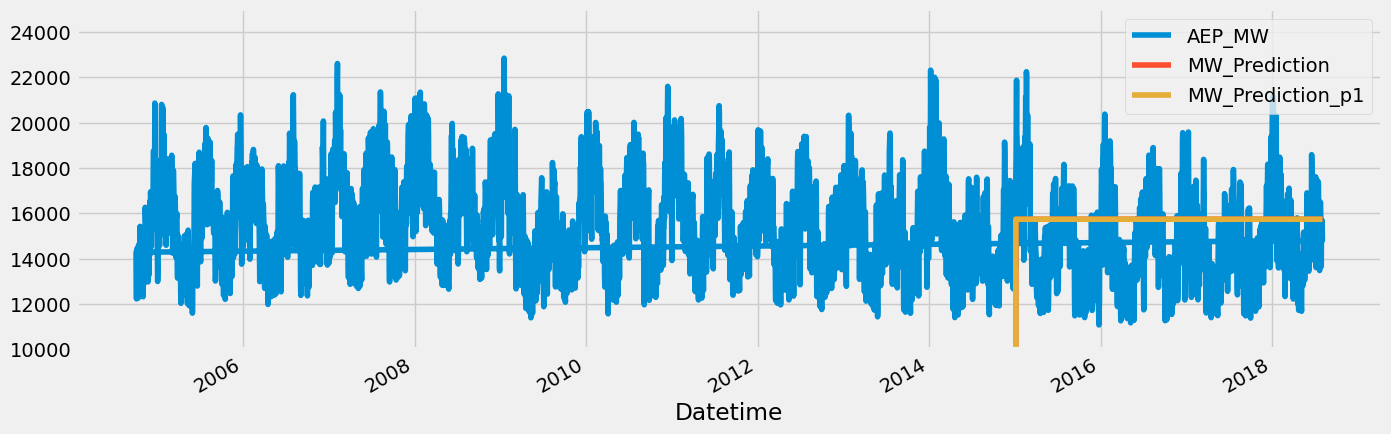

In [19]:
_ = pjme_all[['AEP_MW','MW_Prediction', 'MW_Prediction_p1']].plot(figsize=(15, 5), ylim=(10000, 25000))

## Look at first month of predictions

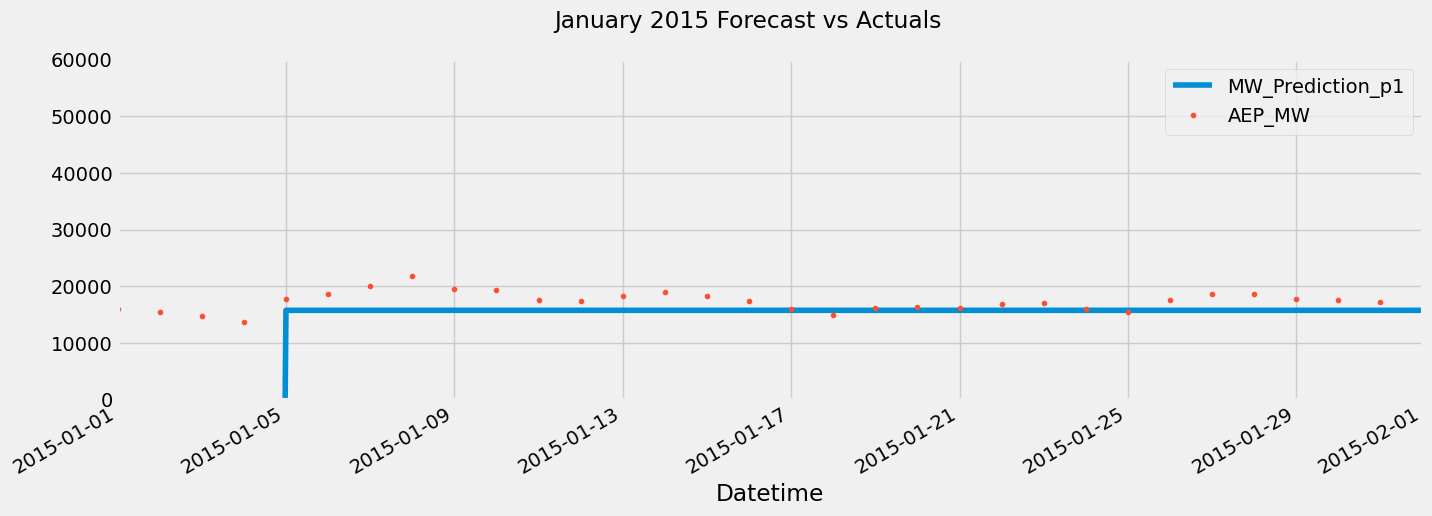

In [20]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction_p1','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

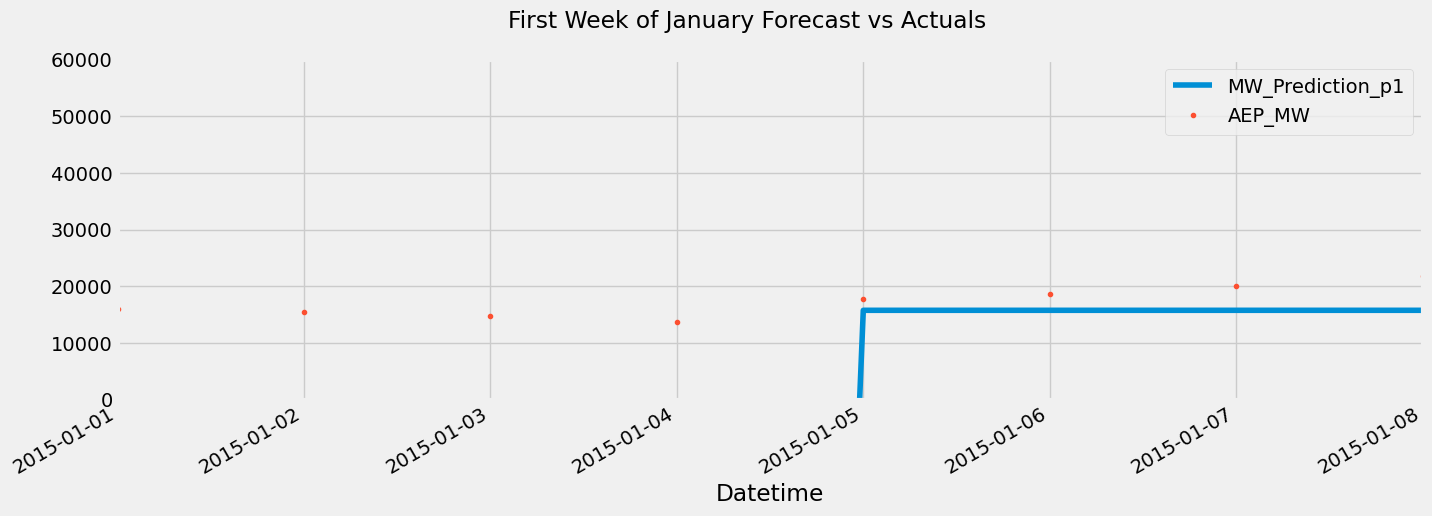

In [21]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction_p1','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

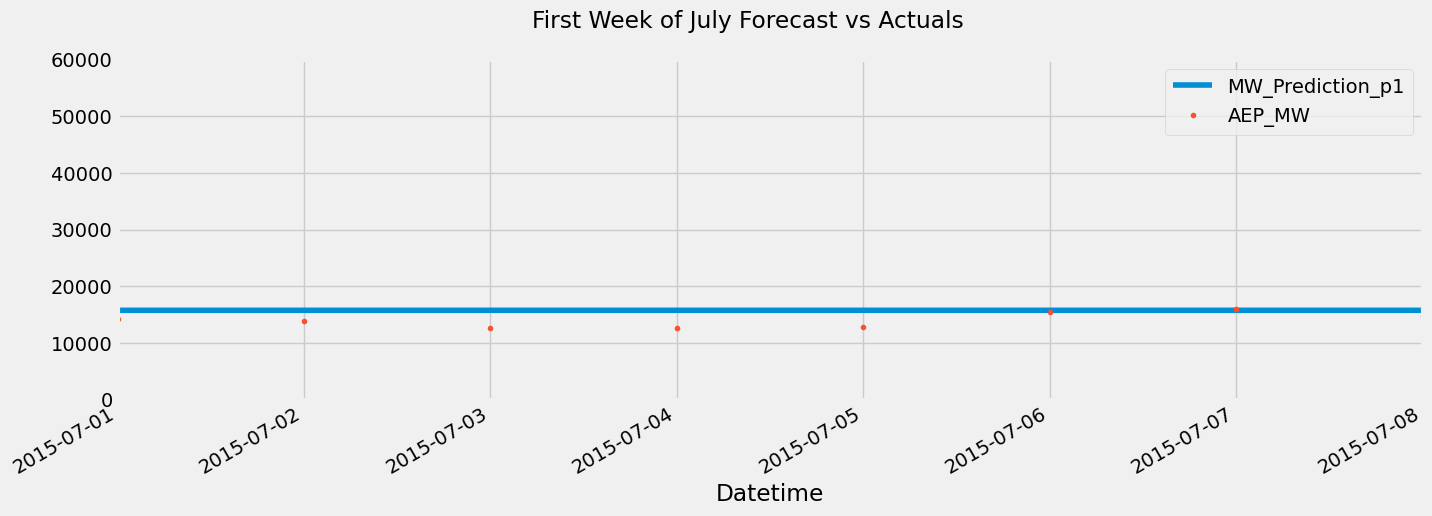

In [22]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction_p1','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

## Error Metrics On Test Set
Our RMSE error is ?

Our MAE error is ?

Our MAPE error is ?

In [23]:
mean_squared_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction_p1'])

5580407781917.814

In [24]:
mean_absolute_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction_p1'])

91390.48678750767

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. MAPE isn't included in sklearn so we need to use a custom function.

In [25]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
mean_absolute_percentage_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction_p1'])

602.3098608680979

## Look at Worst and Best Predicted Days

In [27]:
pjme_test['error'] = pjme_test['AEP_MW'] - pjme_test['MW_Prediction_p1']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']).mean()[['AEP_MW','MW_Prediction_p1','error','abs_error']]

In [28]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

AEP_MW  MW_Prediction_p1        error  \
year month dayofmonth                                                
2015 12    25          11078.041667      15741.612456 -4663.570789   
2016 5     8           11171.083333      15741.612456 -4570.529122   
     3     27          11259.416667      15741.612456 -4482.195789   
     10    2           11264.000000      15741.612456 -4477.612456   
     5     22          11276.791667      15741.612456 -4464.820789   
     10    9           11309.083333      15741.612456 -4432.529122   
     4     23          11366.958333      15741.612456 -4374.654122   
2017 10    1           11379.250000      15741.612456 -4362.362456   
     4     16          11400.291667      15741.612456 -4341.320789   
2015 10    25          11402.541667      15741.612456 -4339.070789   

                         abs_error  
year month dayofmonth               
2015 12    25          4663.570789  
2016 5     8           4570.529122  
     3     27          4482.195789  
     10    2           4477.612456  
     5     22          4464.820789  
     10    9           4432.529122  
     4     23          4374.654122  
2017 10    1           4362.362456  
     4     16          4341.320789  
2015 10    25          4339.070789

Notice anything about the over forecasted days?

<li> worst day - July 4th, 2016 - is a holiday. </li>
<li> worst day - December 25, 2015 - Christmas. </li>
<li> worst day - July 4th, 2016 - is a holiday. </li>
Looks like our model may benefit from adding a holiday indicator.

In [29]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

AEP_MW  MW_Prediction_p1         error  \
year month dayofmonth                                                 
2015 1     2           15515.791667     -7.429262e+07  7.430814e+07   
           3           14698.250000     -4.226989e+07  4.228459e+07   
           4           13634.875000     -7.878791e+05  8.015139e+05   
     2     19          22249.500000      1.574161e+04  6.507888e+03   
           20          22047.041667      1.574161e+04  6.305429e+03   
     1     8           21873.333333      1.574161e+04  6.131721e+03   
2018 1     5           21166.833333      1.574161e+04  5.425221e+03   
2015 2     16          21129.791667      1.574161e+04  5.388179e+03   
2018 1     2           20938.500000      1.574161e+04  5.196888e+03   
           6           20847.833333      1.574161e+04  5.106221e+03   

                          abs_error  
year month dayofmonth                
2015 1     2           7.430814e+07  
           3           4.228459e+07  
           4           8.015139e+05  
     2     19          6.507888e+03  
           20          6.305429e+03  
     1     8           6.131721e+03  
2018 1     5           5.425221e+03  
2015 2     16          5.388179e+03  
2018 1     2           5.196888e+03  
           6           5.106221e+03

The best predicted days seem to be a lot of Dec. (not many holidays and mild weather) Also early may

In [30]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

AEP_MW  MW_Prediction_p1      error  abs_error
year month dayofmonth                                                      
2015 6     25          15742.333333      15741.612456   0.720878   0.720878
2018 7     6           15742.916667      15741.612456   1.304211   1.304211
2015 2     1           15735.541667      15741.612456  -6.070789   6.070789
2018 6     1           15734.666667      15741.612456  -6.945789   6.945789
2015 6     10          15749.666667      15741.612456   8.054211   8.054211
2016 11    21          15730.958333      15741.612456 -10.654122  10.654122
     6     1           15754.625000      15741.612456  13.012544  13.012544
2017 7     6           15727.000000      15741.612456 -14.612456  14.612456
2016 9     10          15772.958333      15741.612456  31.345878  31.345878
2017 6     29          15707.916667      15741.612456 -33.695789  33.695789

Plotting some best/worst predicted days

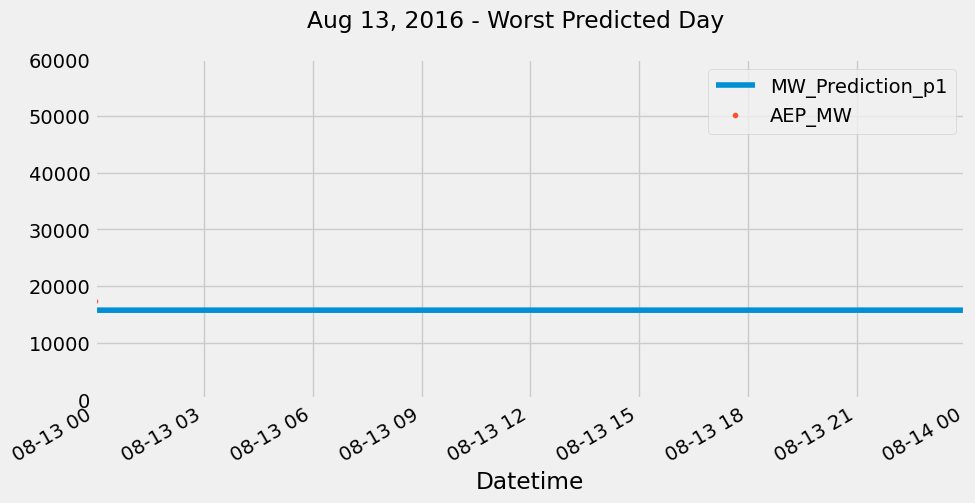

In [31]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction_p1','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

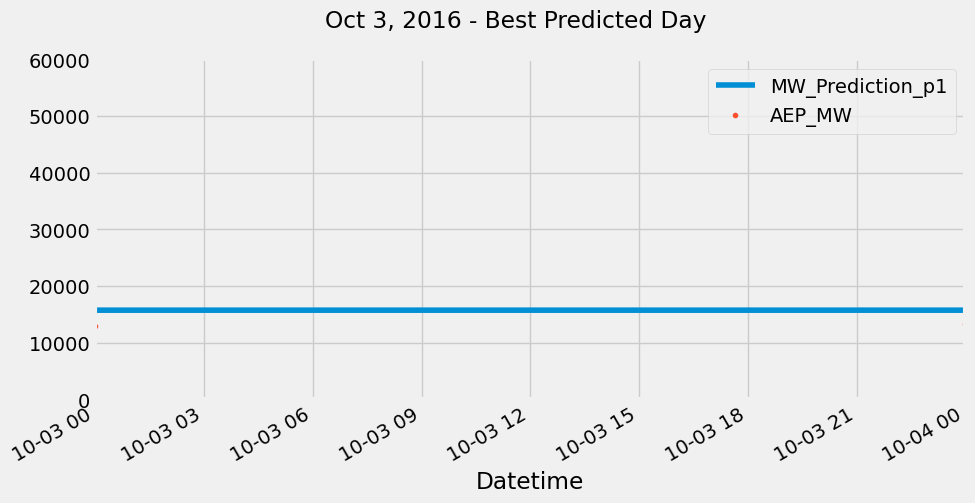

In [32]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction_p1','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

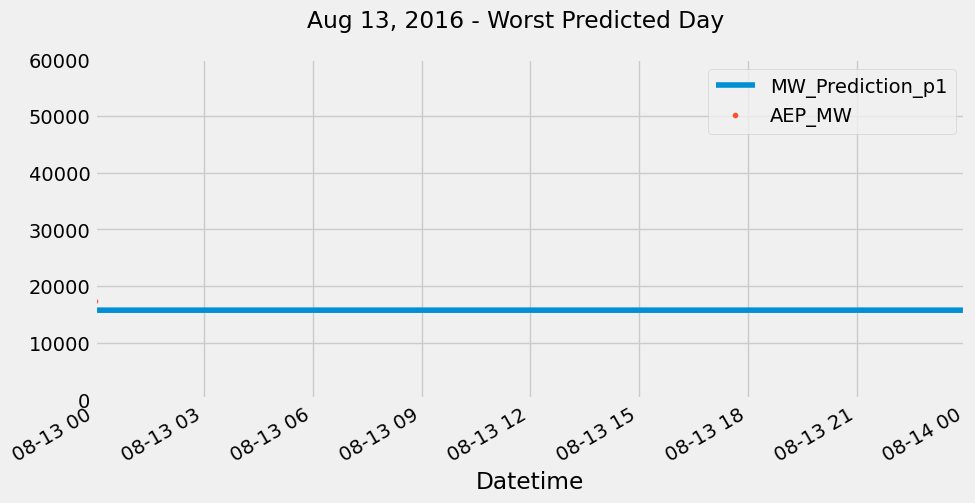

In [33]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction_p1','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

## Up next?
<li>Add Lag variables.</li>
<li>Add holiday indicators.</li>
<li>Add weather data source.</li>
<li>Add other data source empirically correlated to time.</li>